<center><h2>Jewish Newspaper Analysis</h2></center>


# Tasks
    1. Get US jewish newspaper list and corresponding websites
    2. Download 3 years of web  pages from the websites.
    3. Preprocess: Clean, Parse normalize and and clean it
    4. Feature selection (bow,ngrams, embeddings, summaries)
    5. Find Topics using LDA
    6. Get subjects from ChatGpt
    7. Other methods : clustering subjects using vector spacaces and kmeans ,hierarchy clustering, finetuning gpt 3.5 etc..  
    8.Visualization methods(embeddings tsne)
    9.Examples of topics? t
    10.Tools Frameworks, 


# Challenges:
    1. CPU power
    2. Download time  ->use asynch or multicore
    3. Website structute may be diffrent from website to website
    4. Handling erros(formats,timeouts)
    5. Handling irrelevant topics
    6. API usage
    7. Definition of Views, Subjects Topics to test against


# Summary
    1. Define it as a clustering task and use clustering methods (LDA on documents and words,k Means on embeddings)
    2. Use Summary with LLMs (may need to fine tune)

    

<div style = "display: block;margin-left: auto;margin-right: auto;width: 50%;">
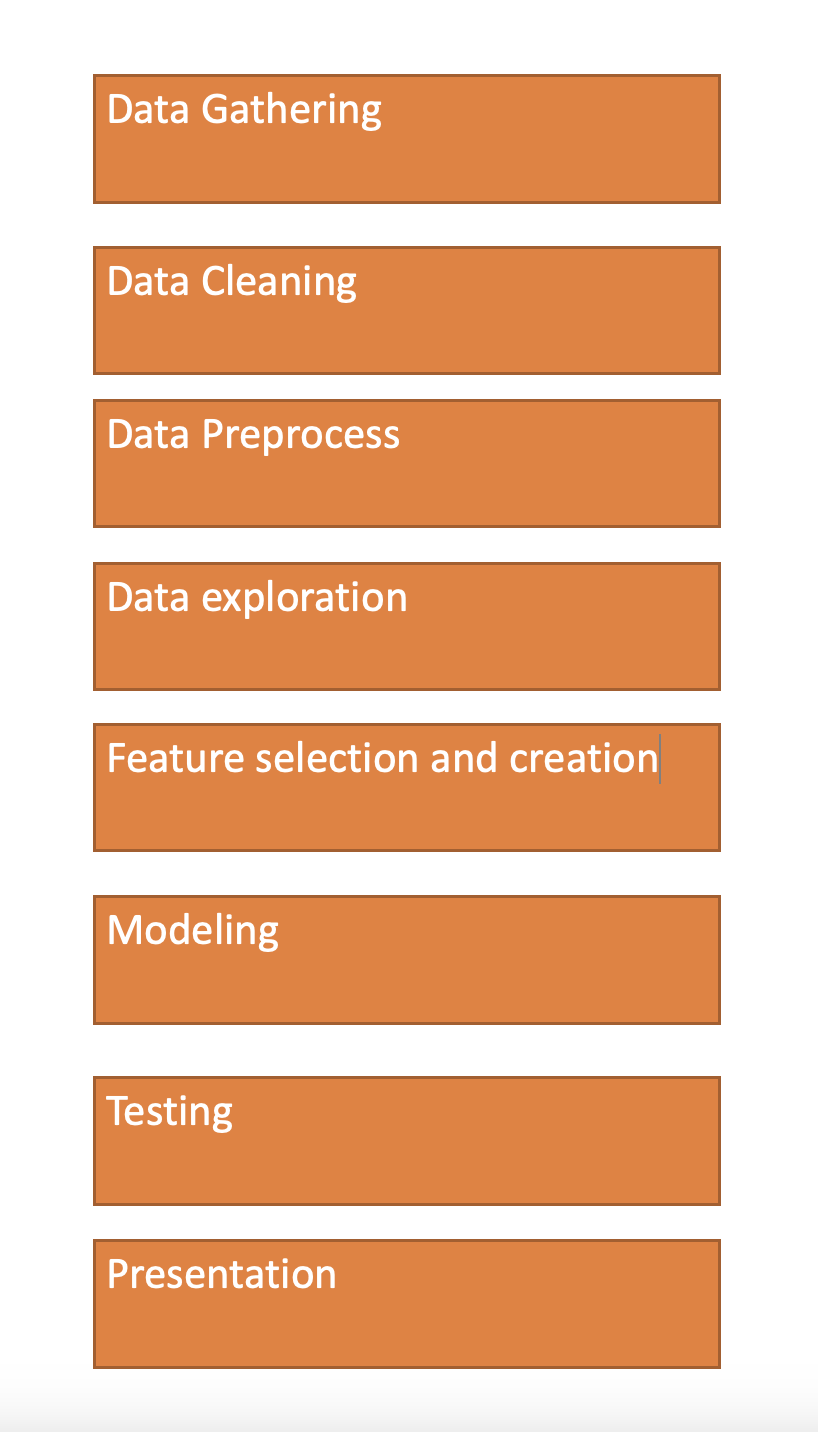
</div>

In [419]:
import openai
import os
import requests
import json
from tqdm.autonotebook import tqdm
from bs4 import BeautifulSoup
import datetime
from  pathlib import Path
from urllib.parse import urlparse
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim import matutils
from sklearn.cluster import KMeans
from collections import defaultdict
from nltk.corpus import stopwords
import pyLDAvis.gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from pprint import pprint
import spacy
import pickle
import re
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import pandas as pd

In [472]:
#  Constants

openai.api_key = "<OPEN_API_KEY>"
api_key = openai.api_key 
org_id = "org-DLaY3pWXSxWCiNQN3Cjv5I4l"
open_api_model_url  = "https://api.openai.com/v1/engines/gpt-3.5-turbo/completions"
url = "https://archive.org/wayback/available?"
time_iter = day_iter(1,1,2021,1,1)
data_dir = "./data/jews-news"

In [ ]:
nltk.download('stopwords')

In [457]:
###---------------------------------------HELPER FUNCTIONS--------------------------------



def tokenize(text):
    text_wordlist = []
    for x in re.split(r"([.,!?\s]+)", text):
        if x and x not in [".", " "] and x.lower() not in stop_words:
            text_wordlist.append(x)
    return(text_wordlist)




def get_batch(texts,batch_size):
    batch = ""
    for t in texts:
        if len(t) + len(batch) <  batch_size:
            batch = batch + t
            continue
        yield batch
        batch = ""


def get_jewish_newspapers_list(n):

    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {api_key}'
    }

    prompt=f"extract {n} most prominent jewish newspapers in the us an and thier websites in a form of a json object , don't assign it to any variable."
    max_tokens = 4000  # Maximum length of the generated completion

    data = {
        'prompt': prompt,
        'max_tokens': max_tokens
    }

    response = requests.post(open_api_model_url, headers=headers, json=data)
    print
    completion = response.json()['choices'][0]['text']
    completion = completion.strip()
    completion.replace("\n","")
    res =json.loads(completion)
    return res

def get_main_views_from_headlines(headlines,n,m):

    text  = "\n".join(headlines)

    text = text[:4000]

    prompt = f"""extract {n} main topics from the text in ``` with each topic  up to {m} words and return them  as as json object.
     ``` {text}```
     """
    response = openai.ChatCompletion.create(
        engine="gpt-3.5-turbo-0613",  # Choose the appropriate engine
        prompt=prompt,
        temperature=0.5
        
      # Adjust as needed
     )
    print(response)


def chatgpt_call(model, prompt, limit):
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-16k", 
        messages = [{"role": "system", "content" : prompt}],
        temperature=0.3

    )
    return completion



###-------------------------------------DATA GATHERING-------------------------------------

def get_jewish_newspapers(n):

    prompt = f"extract {n} most prominent jewish newspapers in the us an and thier websites in a form of a json object , don't assign it to any variable."
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-16k", 
        messages = [{"role": "system", "content" : prompt}]
    )
    newspapers = json.loads(completion["choices"][0]["message"]["content"])
    return newspapers



def gen_url_timestamp(url,site,timestamp):
    return url + "url=" + site + "&" + "timestamp="+ str(timestamp)




def day_iter(d,m,y,days_delta,times):
    time_start = datetime.datetime(y,m,d)
    
    time_end = time_start + datetime.timedelta(times * days_delta)
    time_now = datetime.datetime.now()
    if time_end > time_now:
        time_end = time_now
    time_delta = datetime.timedelta(days_delta)
    day = time_start
    while (day < time_end):
        day_str = day.strftime('%Y%m%d')
        day = day + time_delta
        yield day_str

def download_all(url,urls,data_dir,d,m,y,days,times):
    """
        Download all apges from the newspaper list
    """
    for newspaper in tqdm(urls):
        print(newspaper, end= ' ')
        site_url = urls[newspaper]
        print(f"Downloading Site : {site_url}")
        time_iter = day_iter(d,m,y,days,times)
        try:
            download_site(url,site_url,time_iter,data_dir)
        except Exception as e:
              print(e)
            
def gen_file_name(data_dir,site_name,timestamp):
    domain = urlparse(site_name).netloc
    pathname = Path(data_dir) / (domain + "_" + timestamp + ".html")
    filename = str(pathname.resolve())
    return filename
    
    
def save_file(filename,data):
    with open(filename,"w") as f:
        f.write(data)

def read_file(filename):
    with open(filename,"r") as f:
        data = f.read()
        return data
        
    
def download_page(url):   
    res = requests.get(url)
    content  = res.content.decode("utf-8")
    content = json.loads(content)
    page = content["archived_snapshots"]["closest"]["url"]
    res = requests.get(page)
    content = res.content.decode("utf-8")
    return content


def download_site(url,site_url,time_iter,data_dir):
    for timestamp in tqdm(time_iter):
        url_page = gen_url_timestamp(url,site_url,timestamp)
        try:
            html_page = download_page(url_page)
            filename=gen_file_name(data_dir,site_url,timestamp)
            save_file(filename,html_page)
        except Exception as e:
            print(e)   


def get_all_files(data_dir):
    files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
    for f in files:
        yield f




### ---------------------------------DATA PRE PROCESS-------------------------


def clean_text(text):
    import re
    text   = re.sub(r"[\n\t]+", "", text)
    return text


def filter_stopwords(text):
    """ Irrelevant stop words or subjects """
    
    stopwords =  ["Golden","Dance", "Bingo" , "Gallery","Support Group" ,"Virtual","Game","Mahjong","Slipper","Golden"]
    #re_str = "(" + "|".join(stopwords)+ ")"
    re_str = r"(Golden|Dance|Bingo|Gallery|Support Group|Virtual|Game|Mahjong|Slipper)"

    if re.findall(re_str,text,re.IGNORECASE):
        return False
    return True
  
           
def extract_headlines_from_page(page_html):
    """ Ectract headlines from pages using h2,h2 tags and beautiful soup"""

    headlines = []
    soup = BeautifulSoup(page_html,'html.parser')
    for e in soup.find_all('h2'):
            headlines.append(e.text)
            for s in e.find_next_siblings():
                if s.name == 'p':
                    headline = s.get_text(strip=True)
                    headline = headline.strip()
                    headlines.append(headline)                   
                else:
                    break
    for e in soup.find_all('h3'):
            headlines.append(e.text)
            for s in e.find_next_siblings():
                if s.name == 'p':
                    headline = s.get_text(strip=True)
                    headlines.append(headline)                
                else:
                   break
    headlines = [clean_text(h).strip()    for h in headlines  ]
    headlines = [h   for h in headlines if (len(h.split()) >= 3) ]
    return headlines


def extract_headlines(data_dir):
    """ Ectract headlines from pages(h2,h2 tags)"""
    headlines = []
    
    for f in get_all_files(data_dir):
        try:
            page_html = read_file(f)
            page_headlines = extract_headlines_from_page(page_html)
            headlines.extend(page_headlines)
            #print(page_html)
        except  Exception as e:
            print(e)
            
        
    return headlines

           
def preprocess(text_col):
    """This function will apply NLP preprocessing lambda functions over a pandas series such as df['text'].
       These functions include converting text to lowercase, removing emojis, expanding contractions, removing punctuation,
       removing numbers, removing stopwords, lemmatization, etc."""
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
    # remove emojis
    text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in nltk.corpus.stopwords.words('english') if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col


    
def analyize_page(page_html):
    soup = BeautifulSoup(page_htm,'html.parser')
    
    pass


def print_results():
    pass

def extract_2():
    from urllib.request import urlopen
    from bs4 import BeautifulSoup
    
    url = "http://news.bbc.co.uk/2/hi/health/2284783.stm"
    html = urlopen(url).read()
    soup = BeautifulSoup(html, features="html.parser")
    
    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out
    
    # get text
    text = soup.get_text()
    
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    
    print(text)




###----------------------------------------DATA ANALYSIS---------------------------


def plot_word_cloud(text,filter_list=None):
    if filter_list:
        for word in filter_list:
            text = re.sub(word,"",text,flags = re.IGNORECASE)
        
    """Generate a word cloud image"""
    wordcloud = WordCloud().generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")



def get_all_subjects(texts,m,n):
    batch_gen = get_batch(texts,16385)
    subjects = []
    for  t in tqdm(batch_gen):
        text  = "\n".join(t)
        res = get_main_subjects(text,5)
        subjects.append(res)
    return subjects



def get_lda_topics(docs,n = 10):
    texts =  [ tokenize(h) for h in docs ]
                        
    from gensim import corpora
    from gensim.models.ldamodel import LdaModel
    
    dictionary = corpora.Dictionary(texts)
    # print(dictionary.id2token) ## to see the actual dictionary generated
    corpus = [dictionary.doc2bow(text) for text in texts] ## document to bag of words
    
    # fit LDA model
    transcripts_topics = LdaModel(corpus=corpus,
                               id2word=dictionary,
                               num_topics=n,
                               alpha='auto', ##Learns an asymmetric prior from the corpus;
    ##1D array of length=number of expected topics that expresses our a-priori belief for the each topics’ probability.
                               passes=100 ##Number of passes through the corpus during training.
                                 ) 
    # print out first 5 topics
    for i, topic in enumerate(transcripts_topics.print_topics(5)):
        print ('%d: %s\n'%(i+1, topic))
    
def get_main_subjects(text,n,m=5):

    text = text[:16385]

    prompt = f"""extract {n} main topics from the text in ``` each topic up to  {m} words and return them in a python list format.
     ``` {text} ```"""
    
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-16k", 
        messages = [{"role": "system", "content" : prompt}],
        temperature=0.3

    )
    try:
        subjects.append(completion["choices"][0]["message"]["content"])
        # subjects = json.loads(completion["choices"][0]["message"]["content"])
    except Exception as e:
        print(completion["choices"][0]["message"]["content"])
        print(e)
        return []
    return subjects


def get_all_subjects_async(texts,n=5,m=3):  
    batch_gen = get_batch(texts,16385)
    subjects = []
    with concurrent.futures.ThreadPoolExecutor() as executor:   
        futures = []
        for  t in tqdm(batch_gen):
            text  = "\n".join(t)
            futures.append(executor.submit(get_main_subjects, text,n=n,m=m))
        for future in concurrent.futures.as_completed(futures):
            print(future.result())
            subjects.append(future.result())        
       
    return subjects
    

### MAIN 

def main():
    """
    Get Newspaper from chatgpt query
    Download pages from the archive based upon dates and websites and frquency
    """
    newspapers = get_jewish_newspapers(16)
    download_all(url,newspapers,data_dir,1,8,2021,7,180)
    headlines = extract_headlines(data_dir)
    



In [8]:
headlines = extract_headlines(data_dir)

In [46]:
main()

  0%|          | 0/12 [00:00<?, ?it/s]

The Forward Downloading Site : https://forward.com/


0it [00:00, ?it/s]

'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
The Jewish Journal of Greater Los Angeles Downloading Site : https://jewishjournal.com/


0it [00:00, ?it/s]

'closest'
('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
'closest'
'closest'
The Jewish Press Downloading Site : https://jewishpress.com/


0it [00:00, ?it/s]

'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
The Jewish Daily Forward Downloading Site : https://forward.com/


0it [00:00, ?it/s]

'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
The Algemeiner Downloading Site : https://www.algemeiner.com/


0it [00:00, ?it/s]

'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
'closest'
The Jewish Exponent Downloading Site : https://www.jewishexponent.com/


0it [00:00, ?it/s]

'closest'
'closest'
'closest'
'closest'
HTTPSConnectionPool(host='archive.org', port=443): Max retries exceeded with url: /wayback/available?url=https://www.jewishexponent.com/&timestamp=20230723 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x17bd116d0>: Failed to establish a new connection: [Errno 60] Operation timed out'))
The New York Jewish Week Downloading Site : https://jewishweek.timesofisrael.com/


0it [00:00, ?it/s]

'closest'
'closest'
'closest'
Haaretz Downloading Site : https://www.haaretz.com/


0it [00:00, ?it/s]

'closest'
'closest'
'closest'
'closest'
HTTPConnectionPool(host='web.archive.org', port=80): Max retries exceeded with url: /web/20221219000224/http://www.haaretz.com/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x17bd21250>: Failed to establish a new connection: [Errno 60] Operation timed out'))
HTTPSConnectionPool(host='archive.org', port=443): Max retries exceeded with url: /wayback/available?url=https://www.haaretz.com/&timestamp=20230319 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x17bd18040>: Failed to establish a new connection: [Errno 60] Operation timed out'))
'closest'
("Connection broken: InvalidChunkLength(got length b'', 0 bytes read)", InvalidChunkLength(got length b'', 0 bytes read))
The Times of Israel Downloading Site : https://www.timesofisrael.com/


0it [00:00, ?it/s]

'utf-8' codec can't decode bytes in position 65948-65949: invalid continuation byte
'closest'
'closest'
The Jewish Telegraphic Agency (JTA) Downloading Site : https://www.jta.org/


0it [00:00, ?it/s]

'utf-8' codec can't decode byte 0xbb in position 14288: invalid start byte
'utf-8' codec can't decode byte 0xbb in position 15016: invalid start byte
'utf-8' codec can't decode byte 0xbb in position 15194: invalid start byte
'utf-8' codec can't decode byte 0xaf in position 15194: invalid start byte
'utf-8' codec can't decode byte 0xbb in position 15185: invalid start byte
'utf-8' codec can't decode byte 0xbb in position 15967: invalid start byte
'utf-8' codec can't decode byte 0xbb in position 15976: invalid start byte
'utf-8' codec can't decode byte 0xbb in position 15976: invalid start byte
'utf-8' codec can't decode byte 0xc8 in position 16363: invalid continuation byte
'utf-8' codec can't decode byte 0xbb in position 16452: invalid start byte
HTTPSConnectionPool(host='archive.org', port=443): Max retries exceeded with url: /wayback/available?url=https://www.jta.org/&timestamp=20220515 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x17bd2cee0>: Failed 

0it [00:00, ?it/s]

HTTPSConnectionPool(host='archive.org', port=443): Max retries exceeded with url: /wayback/available?url=https://www.jpost.com/&timestamp=20210815 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x17f925df0>: Failed to establish a new connection: [Errno 60] Operation timed out'))
HTTPConnectionPool(host='web.archive.org', port=80): Max retries exceeded with url: /web/20220110001949/http://www.jpost.com/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x17f98f280>: Failed to establish a new connection: [Errno 60] Operation timed out'))
HTTPSConnectionPool(host='archive.org', port=443): Max retries exceeded with url: /wayback/available?url=https://www.jpost.com/&timestamp=20220116 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x17bd184f0>: Failed to establish a new connection: [Errno 60] Operation timed out'))
'closest'
'closest'
HTTPConnectionPool(host='web.archive.org', port=80): Max retries exceede

0it [00:00, ?it/s]

'closest'
'closest'
'closest'


In [212]:
#newspapers = get_jewish_newspapers_list(10)
#download_all(url,newspapers,data_dir,1,8,2020,1,1)

In [50]:
headlines  = extract_headlines(data_dir)

'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte


In [427]:
clean_headlines = [h for h in headlines if filter_stopwords(h)]
text = "\n".join(clean_headlines)


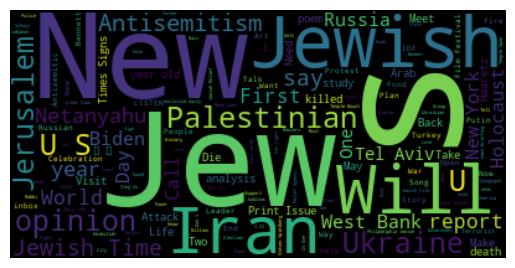

In [445]:
plot_word_cloud(text,["israel"])

In [241]:
subjects = get_all_subjects_async(texts)

0it [00:00, ?it/s]

[['Jewish issues', 'Supreme Court', 'Israeli film', "Men's health", 'Hanukkah shopping'], ['Jewish cooking', 'Food influencer Eitan Bernath', 'Hunger relief efforts', "Israel's COVID-19 vaccine", 'Jewish refugees in Japan'], ["Missouri Mayor Apologizes After Saying Trash Collectors Are 'Not Trying to...Racist Chants", 'Shooting in Buffalo Brought Jewish, Black Communities Together. What Took...Chutzpah', "Orthodox Pop Star Ishay Ribo Will be First Israeli to...Traumatic Brain Injury 'Funda' Creators Debut 'Ghosts of Beirut,' Showtime Series About Mossad's Killing...Nancy Spielsberg: 'We Have to Get People Back into the Theater'", "Cherry Hill Teacher Shares Experience on Netflix's 'Jewish Matchmaking'", 'Congregation Kol Emet Introducing New Outdoor Contemplative Space', "Last Word: Keren Keshet Leads Philadelphia's Israel Scouts 'Outpouring of Support' Helps Temple Judea Stay on Central Bucks Property"], ['Israeli-Arab Men Have Highest Rate of Lung Cancer, Arab Women the Lowest', 'Isr

RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-DLaY3pWXSxWCiNQN3Cjv5I4l on tokens per min. Limit: 180000 / min. Current: 178904 / min. Contact us through our help center at help.openai.com if you continue to have issues.

In [242]:
subjects

[['Jewish issues',
  'Supreme Court',
  'Israeli film',
  "Men's health",
  'Hanukkah shopping'],
 ['Jewish cooking',
  'Food influencer Eitan Bernath',
  'Hunger relief efforts',
  "Israel's COVID-19 vaccine",
  'Jewish refugees in Japan'],
 ["Missouri Mayor Apologizes After Saying Trash Collectors Are 'Not Trying to...Racist Chants",
  'Shooting in Buffalo Brought Jewish, Black Communities Together. What Took...Chutzpah',
  "Orthodox Pop Star Ishay Ribo Will be First Israeli to...Traumatic Brain Injury 'Funda' Creators Debut 'Ghosts of Beirut,' Showtime Series About Mossad's Killing...Nancy Spielsberg: 'We Have to Get People Back into the Theater'",
  "Cherry Hill Teacher Shares Experience on Netflix's 'Jewish Matchmaking'",
  'Congregation Kol Emet Introducing New Outdoor Contemplative Space',
  "Last Word: Keren Keshet Leads Philadelphia's Israel Scouts 'Outpouring of Support' Helps Temple Judea Stay on Central Bucks Property"],
 ['Israeli-Arab Men Have Highest Rate of Lung Cancer,

In [274]:
texts = []
for s in subjects:
    if type(s) == str:
       if not filter_stopwords(str(s)):
            continue
       s= s.strip()
       s= s.replace("\n","")
       re.split("[0-9]\.",s))
       continue
    texts.append(s)
      

In [275]:
texts

[['Jewish issues',
  'Supreme Court',
  'Israeli film',
  "Men's health",
  'Hanukkah shopping'],
 ['Jewish cooking',
  'Food influencer Eitan Bernath',
  'Hunger relief efforts',
  "Israel's COVID-19 vaccine",
  'Jewish refugees in Japan'],
 ["Missouri Mayor Apologizes After Saying Trash Collectors Are 'Not Trying to...Racist Chants",
  'Shooting in Buffalo Brought Jewish, Black Communities Together. What Took...Chutzpah',
  "Orthodox Pop Star Ishay Ribo Will be First Israeli to...Traumatic Brain Injury 'Funda' Creators Debut 'Ghosts of Beirut,' Showtime Series About Mossad's Killing...Nancy Spielsberg: 'We Have to Get People Back into the Theater'",
  "Cherry Hill Teacher Shares Experience on Netflix's 'Jewish Matchmaking'",
  'Congregation Kol Emet Introducing New Outdoor Contemplative Space',
  "Last Word: Keren Keshet Leads Philadelphia's Israel Scouts 'Outpouring of Support' Helps Temple Judea Stay on Central Bucks Property"],
 ['Israeli-Arab Men Have Highest Rate of Lung Cancer,

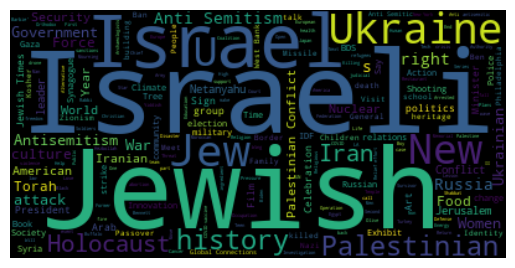

In [324]:
flatten_subjects = [x for y in texts for x in y if filter_stopwords(x)]
text = "\n".join(flatten_subjects)
plot_word_cloud(text)

In [325]:
flatten_subjects

['Jewish issues',
 'Supreme Court',
 'Israeli film',
 "Men's health",
 'Hanukkah shopping',
 'Jewish cooking',
 'Food influencer Eitan Bernath',
 'Hunger relief efforts',
 "Israel's COVID-19 vaccine",
 'Jewish refugees in Japan',
 "Missouri Mayor Apologizes After Saying Trash Collectors Are 'Not Trying to...Racist Chants",
 'Shooting in Buffalo Brought Jewish, Black Communities Together. What Took...Chutzpah',
 "Orthodox Pop Star Ishay Ribo Will be First Israeli to...Traumatic Brain Injury 'Funda' Creators Debut 'Ghosts of Beirut,' Showtime Series About Mossad's Killing...Nancy Spielsberg: 'We Have to Get People Back into the Theater'",
 "Cherry Hill Teacher Shares Experience on Netflix's 'Jewish Matchmaking'",
 'Congregation Kol Emet Introducing New Outdoor Contemplative Space',
 "Last Word: Keren Keshet Leads Philadelphia's Israel Scouts 'Outpouring of Support' Helps Temple Judea Stay on Central Bucks Property",
 'Israeli-Arab Men Have Highest Rate of Lung Cancer, Arab Women the Lowe

In [311]:
docs = flatten_subjects 

In [326]:
get_lda_topics(docs)

LdaModel<num_terms=2242, num_topics=10, decay=0.5, chunksize=2000>
1: (9, '0.013*"Israeli" + 0.009*"Ukraine" + 0.007*", " + 0.007*"Russia" + 0.007*"relations" + 0.007*"War" + 0.007*"conflict" + 0.004*". " + 0.004*"sanctions" + 0.004*"U"')

2: (0, '0.027*"Anti-Semitism" + 0.010*"Jews" + 0.008*"Israeli" + 0.008*"history" + 0.006*"-" + 0.004*"?" + 0.004*"Rights" + 0.004*"Human" + 0.004*"Russian" + 0.004*"Financial"')

3: (7, '0.033*"Jewish" + 0.020*"Israel" + 0.017*", " + 0.013*"Israeli" + 0.010*"Times" + 0.008*"Signs" + 0.008*"Israel\'s" + 0.008*"New" + 0.008*"Palestinian" + 0.006*"Says"')

4: (6, '0.050*"Jewish" + 0.020*"Israel\'s" + 0.019*"Holocaust" + 0.012*"History" + 0.009*"history" + 0.009*"Torah" + 0.008*", " + 0.008*"Food" + 0.006*"Israeli" + 0.005*"Israel"')

5: (8, '0.078*"Jewish" + 0.032*"Israeli" + 0.007*"Society" + 0.006*", " + 0.006*"World" + 0.006*"War" + 0.005*"US" + 0.005*"Philadelphia" + 0.005*"Syria" + 0.005*"Christian"')



In [330]:
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [332]:
# https://www.kaggle.com/code/ykhorramz/lda-and-t-sne-interactive-visualization
# https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know

In [329]:
pyLDAvis.gensim.prepare(model, corpus, dictionary)


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.6 MB 868 kB/s eta 0:00:01
     |████████████████████████████████| 90 kB 3.4 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [335]:
headlines[:3]

['2021 ADL Walk Against Hate',
 'Get A Jump Start on Chanukah Shopping',
 'MBIEE Men’s Club Presents: Men’s Health – Urologic Issues']

In [352]:
clean_headlines = [h for h in headlines if filter_stopwords(h)]


In [353]:
tokens = [h.split() for h in clean_headlines]


In [401]:
def decap(word):
    if word.istitle():
        word = word.lower()
        word = WordNetLemmatizer().lemmatize(word)
    return word

tokens_decapitalize = []
for line in tokens:
    new_line = [decap(word) for word in line if word not in stopwords.words('english')]
    tokens_decapitalize.append(new_line)
tokens =   tokens_decapitalize 

In [410]:
text_line = ""
for line in tokens:
    sentence = " ".join(line)
    text_line+=sentence


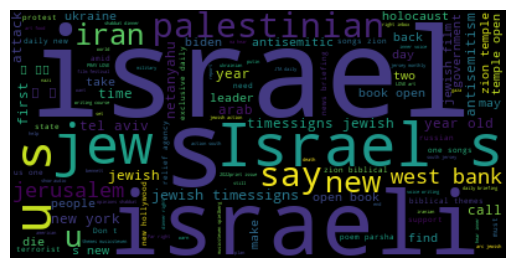

In [411]:
plot_word_cloud(text_line)

In [408]:
tokens

[['2021', 'ADL', 'walk', 'hate'],
 ['get', 'jump', 'start', 'chanukah', 'shopping'],
 ['MBIEE',
  'Men’s',
  'club',
  'presents:',
  'Men’s',
  'health',
  '–',
  'urologic',
  'issues'],
 ['2021',
  'supreme',
  'Court’s',
  'jewish',
  'issues:',
  'abortion,',
  'church-state',
  'separation,',
  'painting…'],
 ['neal',
  'sher,',
  'nazi',
  'hunter',
  'former',
  'AIPAC',
  'director,',
  'dies',
  '74'],
 ['story', 'palestinians', 'Israel’s', 'highest', 'film', 'honor.', 'stars…'],
 ['jewish', 'radio', 'show', 'aims', 'connect', 'local', 'singles'],
 ['pennsylvania', 'needs', 'Driver’s', 'licenses'],
 ['made', 'podcast', 'father', 'coughlin'],
 ['like', 'america,', 'genesis', 'two', 'distinct', 'stories', 'creation'],
 ['jews', 'concerned', 'hyphens?'],
 ['‘velvet', 'underground’', 'withstands', 'test', 'time'],
 ['story', 'palestinians', 'Israel’s', 'highest', 'film', 'honor.', 'stars…'],
 ['‘velvet', 'underground’', 'withstands', 'test', 'time'],
 ['jon', 'stewart', 'returns'

In [402]:
id2word = Dictionary(tokens)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tokens]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [403]:
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]


[[('2021', 1), ('ADL', 1), ('hate', 1), ('walk', 1)]]

In [404]:
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=10,
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.054*"celebration" + 0.051*"trees" + 0.049*"out:" + 0.049*"branching" + '
  '0.031*"palestinian" + 0.023*"killed" + 0.018*"police" + 0.015*"minister" + '
  '0.015*"climate" + 0.013*"fight"'),
 (1,
  '0.089*"israeli" + 0.028*"iran" + 0.020*"get" + 0.016*"hanukkah" + '
  '0.016*"u.s." + 0.013*"one" + 0.012*"daily" + 0.012*"8" + '
  '0.011*"antisemitic" + 0.011*"ocean"'),
 (2,
  '0.102*"–" + 0.021*"news" + 0.016*"israelis" + 0.016*"netanyahu" + '
  '0.015*"court" + 0.014*"course" + 0.014*"hear" + 0.014*"voice:" + '
  '0.013*"military" + 0.013*"inner"'),
 (3,
  '0.165*"jewish" + 0.018*"philadelphia" + 0.017*"holocaust" + 0.015*"david" + '
  '0.013*"history" + 0.013*"mind" + 0.012*"attack" + 0.012*"life’" + '
  '0.012*"deal" + 0.012*"media"'),
 (4,
  '0.022*"big" + 0.019*"tel" + 0.018*"|" + 0.017*"presents" + 0.014*"issue:" + '
  '0.014*"print" + 0.013*"high" + 0.013*"books" + 0.013*"days" + 0.012*"aviv"'),
 (5,
  '0.041*"Israel’s" + 0.033*"US" + 0.019*"film" + 0.019*"2022" + '
  '

In [405]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.308729 -0.295322       1        1  18.591805
6     -0.268131  0.330980       2        1  18.555849
3      0.046807 -0.007376       3        1  11.036866
1      0.064789 -0.009193       4        1  10.930271
7      0.079343 -0.005524       5        1   8.829242
2      0.074095 -0.003077       6        1   8.188424
5      0.078691 -0.004676       7        1   7.638550
0      0.076348  0.000573       8        1   6.478302
9      0.077849 -0.006142       9        1   5.009775
4      0.078938 -0.000243      10        1   4.740918, topic_info=          Term         Freq        Total Category  logprob  loglift
21      jewish  7896.000000  7896.000000  Default  30.0000  30.0000
145     israel  6248.000000  6248.000000  Default  29.0000  29.0000
214    israeli  4192.000000  4192.000000  Default  28.0000  28.0000
16           –  3605.000000  3605.000000  Default  27.0000  27.0000
110        new  3572.000000  3572.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1251        LA   161.853489   162.900830  Topic10  -4.8418   3.0425
2762  hashanah   155.514982   156.562235  Topic10  -4.8818   3.0422
4243     LGBTQ   155.052635   156.099974  Topic10  -4.8847   3.0422
2356     kills   152.300184   153.347541  Topic10  -4.9026   3.0421
7481   players   145.445215   146.492617  Topic10  -4.9487   3.0418

[333 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
211       5  0.999191          &
3600      1  0.998782       (AP)
3593      1  0.999418  (haaretz)
3611      1  0.653190  (reuters)
3611      2  0.346113  (reuters)
...     ...       ...        ...
16        6  0.999694          –
137       5  0.998959          —
5011      5  0.993088         ‘i
5638      3  0.998747    ‘moses:
529       5  0.998137       ‘the

[304 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 4, 2, 8, 3, 6, 1, 10, 5])

In [ ]:
tokens = [h.split() for h in flatten_subjects]
id2word = Dictionary(tokens)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tokens]

In [360]:
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]


[[('2021', 1), ('ADL', 1), ('Against', 1), ('Hate', 1), ('Walk', 1)]]

In [361]:
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=10,
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.062*"Our" + 0.033*"Israel’s" + 0.019*"We" + 0.018*"Why" + 0.018*"your" + '
  '0.015*"American" + 0.015*"2022" + 0.013*"Shabbat" + 0.012*"news" + '
  '0.012*"It"'),
 (1,
  '0.133*"at" + 0.041*"says" + 0.030*"(AP)" + 0.030*"Philadelphia" + '
  '0.024*"Hanukkah" + 0.021*"Israelis" + 0.016*"Ocean" + 0.016*"Casino" + '
  '0.016*"Menu" + 0.013*"Dies"'),
 (2,
  '0.103*"of" + 0.082*"to" + 0.080*"in" + 0.077*"the" + 0.038*"a" + 0.029*"on" '
  '+ 0.024*"with" + 0.017*"-" + 0.014*"(Haaretz)" + 0.009*"from"'),
 (3,
  '0.040*"Your" + 0.038*"(Reuters)" + 0.037*"How" + 0.026*"Iran" + '
  '0.022*"Palestinian" + 0.022*"US" + 0.021*"From" + 0.019*"Russia" + '
  '0.018*"Jerusalem" + 0.016*"Can"'),
 (4,
  '0.147*"and" + 0.147*"Jewish" + 0.014*"Are" + 0.013*"For" + 0.012*"into" + '
  '0.012*"are" + 0.011*"Human" + 0.010*"South" + 0.010*"Writing" + '
  '0.009*"Two"'),
 (5,
  '0.082*"Israel" + 0.036*"New" + 0.032*"is" + 0.031*"Times" + 0.028*"Signs" + '
  '0.027*"Ukraine" + 0.021*"Rabbi" + 0.014*"I

In [362]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.437975  0.087944       1        1  32.490485
5     -0.048216 -0.414416       2        1  12.493033
8      0.052416  0.034366       3        1   9.124527
4      0.041940  0.049985       4        1   9.085138
3      0.045898  0.057139       5        1   8.419111
9      0.063878  0.040664       6        1   7.675781
7      0.041595  0.054429       7        1   7.490717
0      0.074648  0.035205       8        1   6.258777
1      0.081209  0.029638       9        1   3.958615
6      0.084606  0.025047      10        1   3.003816, topic_info=           Term          Freq         Total Category  logprob  loglift
79           of  19707.000000  19707.000000  Default  30.0000  30.0000
35          and   7856.000000   7856.000000  Default  29.0000  29.0000
22       Jewish   7827.000000   7827.000000  Default  28.0000  28.0000
124          in  15269.000000  15269.000000  Default  27.0000  27.0000
57           to  15708.000000  15708.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
3762       need    130.712003    131.739703  Topic10  -4.9048   3.4975
1444     Tehran    124.483318    125.510904  Topic10  -4.9536   3.4971
2412  president    124.248719    125.276345  Topic10  -4.9555   3.4971
2410        UAE    123.231935    124.259503  Topic10  -4.9637   3.4970
146         Yom    118.079778    119.107334  Topic10  -5.0065   3.4966

[332 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
254       3  0.998798          &
4078      9  0.998693       (AP)
4085     10  0.996379      (DPA)
4066      1  0.999546  (Haaretz)
4096      5  0.999576  (Reuters)
...     ...       ...        ...
1161      1  0.998421       פֿון
19        7  0.999535          –
168       1  0.998327          —
6697      3  0.998404    ‘Moses:
607       3  0.998106       ‘The

[308 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 9, 5, 4, 10, 8, 1, 2, 7])

In [460]:
newsp = get_jewish_newspapers(16)

In [462]:
import pandas as pd

In [463]:
newsp

{'The Forward': 'https://forward.com/',
 'The Jewish Daily Forward': 'https://forward.com/',
 'The Jewish Week': 'https://jewishweek.timesofisrael.com/',
 'The New York Jewish Week': 'https://jewishweek.timesofisrael.com/',
 'The Times of Israel': 'https://www.timesofisrael.com/',
 'Jewish Telegraphic Agency (JTA)': 'https://www.jta.org/',
 'The Jewish Journal of Greater Los Angeles': 'https://jewishjournal.com/',
 'Jewish Exponent': 'https://jewishexponent.com/',
 'The Algemeiner Journal': 'https://www.algemeiner.com/',
 'The American Israelite': 'https://www.americanisraelite.com/',
 'The Cleveland Jewish News': 'https://www.clevelandjewishnews.com/',
 'Haaretz': 'https://www.haaretz.com/',
 'The Jerusalem Post': 'https://www.jpost.com/',
 'The Jewish Chronicle': 'https://www.thejc.com/',
 'The Canadian Jewish News': 'https://www.cjnews.com/',
 'Jewish Telegraphic Agency - Europe': 'https://www.jta.org/category/news-opinion/europe'}

In [464]:
newspaper_name = newsp.keys()

In [465]:
newspaper_website = newsp.values()

In [466]:
newspaper_website

dict_values(['https://forward.com/', 'https://forward.com/', 'https://jewishweek.timesofisrael.com/', 'https://jewishweek.timesofisrael.com/', 'https://www.timesofisrael.com/', 'https://www.jta.org/', 'https://jewishjournal.com/', 'https://jewishexponent.com/', 'https://www.algemeiner.com/', 'https://www.americanisraelite.com/', 'https://www.clevelandjewishnews.com/', 'https://www.haaretz.com/', 'https://www.jpost.com/', 'https://www.thejc.com/', 'https://www.cjnews.com/', 'https://www.jta.org/category/news-opinion/europe'])

In [468]:
import pandas as pd

In [470]:
pd.DataFrame( data = {"newspaper name":newspaper_name,"newspaper_website":newspaper_website})

,newspaper name,newspaper_website
0,The Forward,https://forward.com/
1,The Jewish Daily Forward,https://forward.com/
2,The Jewish Week,https://jewishweek.timesofisrael.com/
3,The New York Jewish Week,https://jewishweek.timesofisrael.com/
4,The Times of Israel,https://www.timesofisrael.com/
5,Jewish Telegraphic Agency (JTA),https://www.jta.org/
6,The Jewish Journal of Greater Los Angeles,https://jewishjournal.com/
7,Jewish Exponent,https://jewishexponent.com/
8,The Algemeiner Journal,https://www.algemeiner.com/
9,The American Israelite,https://www.americanisraelite.com/
